In [1]:
import pint
import os, sys
from utils import *

lib_path = get_project_root()
sys.path.insert(0, lib_path)

from lib.calculator import LinkBudgetCalculator

In [2]:
ureg = pint.UnitRegistry()

# create the linkBudgetCalculator object
lb_calc = LinkBudgetCalculator(ureg)

## Analysis of Design Iteration 2

### Description

<br>
This analysis was done with a simple monopole whip antenna as the receiver.
<br>

![alt text](block_diagram_monopole.png "Block Diagram")
*<p style="text-align: center;">Block Diagram</p>*


### Setup of Ground Station Values

<br>
Values for specific ground station are below:

In [3]:
lb_calc.altitude_ground_station   =  400 * ureg.meter
lb_calc.implementation_loss       = -1.0   # dB
lb_calc.polarization_losses       = -3.0   # dB
lb_calc.receive_antenna_gain      =  5.0   # dB
lb_calc.system_noise_figure       =  5.0   # dB

### Setup of Satellite Values

Values stated for a certain NOAA satellite. These values are covered in the documentation.

In [4]:
lb_calc.altitude_satellite        =  860 * ureg.kilometer
lb_calc.transmit_power            =  5.0 * ureg.watt
lb_calc.transmit_losses           = -1.0   # dB
lb_calc.transmit_antenna_gain     =  4.0   # dBi

### Setup of Additional Values

Create functions for the changing elevation angle and atmospheric loss values.

In [5]:
# receive pointing loss for given elevation (at our frequency)
# these values are different for each antenna system, so the values are defined here for clarity
# see referenced antenna specifications for more information
def rx_pointing_loss_at_elev(elev):
    return  0.0  if elev < 10  * ureg.degrees else \
           -1.0  if elev < 20 * ureg.degrees else \
           -2.0  if elev < 40 * ureg.degrees else \
           -5.0  if elev < 50 * ureg.degrees else \
           -10.0 if elev < 70 * ureg.degrees else \
           -14.0 if elev < 80 * ureg.degrees else -24.0

Set paramaters for the analysis here

Additional values are needed for the channel characteristics. A few of these values will change during an orbital pass!

In [6]:
lb_calc.orbit_elevation_angle     =  0.001          * ureg.degrees
lb_calc.downlink_frequency        =  137.5          * ureg.megahertz
lb_calc.target_energy_noise_ratio =  20.0             # dB
lb_calc.noise_bandwidth           =  34.0           * ureg.kilohertz
lb_calc.transmit_pointing_loss    = -3.0              # dB
lb_calc.atmospheric_loss          =  atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
lb_calc.receiving_pointing_loss   =  rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

### Analysis

Define variables for running a sweep over an orbital pass.

Increment through an entire orbital pass.

In [7]:
# get the elevation angles of different pass types using a TLE
# use an old TLE (line0, line1, line2)
tle_old = ('NOAA 19 [+]', '1 33591U 09005A   18092.90091581  .00000055  00000-0  55075-4 0  9994',
       '2 33591  99.1353  69.4619 0014005 174.2137 185.9198 14.12266303471284')
results = []
# poor pass
#results.append(compute_angles(tle=tle_old, date='2018/04/03 02:00.00'))
results.append( angles_poor )
# average pass
#results.append(compute_angles(tle=tle_old, date='2018/04/03 10:00.00'))
results.append( angles_good )
# excellent pass
#results.append(compute_angles(tle=tle_old, date='2018/04/01 06:00.00'))
results.append( angles_great )

outputs = []
outputs.append([])
outputs.append([])
outputs.append([])

for n, res in enumerate(results):
    for i, angle in enumerate(res[1]):
        # compute the budget
        lb_calc.run()

        # ensure the computation was valid
        if not lb_calc.is_valid:
            raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')

        # save output as a tuple to output list
        outputs[n].append( (lb_calc.link_distance, \
                         lb_calc.downlink_path_loss, \
                         lb_calc.received_power, \
                         lb_calc.energy_noise_ratio, \
                         lb_calc.link_margin) )

        # increment the elevation angle
        lb_calc.orbit_elevation_angle     = angle * ureg.degrees
        lb_calc.atmospheric_loss          = atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
        lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

# DEBUG
print('Max poor elevation angle: {}'.format(max(results[0][1])))
print('Duration of poor pass: {}'.format(results[0][2][-1] - results[0][2][0]))
print('Max average elevation angle: {}'.format(max(results[1][1])))
print('Duration of average pass: {}'.format(results[1][2][-1] - results[1][2][0]))
print('Max good elevation angle: {}'.format(max(results[2][1])))
print('Duration of good pass: {}'.format(results[2][2][-1] - results[2][2][0]))

Max poor elevation angle: 11.132293955545649
Duration of poor pass: 0:12:34.999722
Max average elevation angle: 33.03981409098066
Duration of average pass: 0:15:09.999876
Max good elevation angle: 75.95193579697357
Duration of good pass: 0:16:06.999473


Once analysis has run, examine the results.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# extract lists of the variables
distances = []
loss = []
rx_pow = []
eb_no = []
margins = []
for j in range(0, 3):
    distances.append([ i[0].magnitude for i in outputs[j] ])
    loss.append(     [ i[1] for i in outputs[j] ])
    rx_pow.append(   [ i[2] for i in outputs[j] ])
    eb_no.append(    [ i[3] for i in outputs[j] ])
    margins.append(  [ i[4] for i in outputs[j] ])

Duration for Poor pass above margin: 0 seconds (0.0 minutes)
Duration for Average pass above margin: 142 seconds (2.37 minutes)
Duration for Good pass above margin: 123 seconds (2.05 minutes)


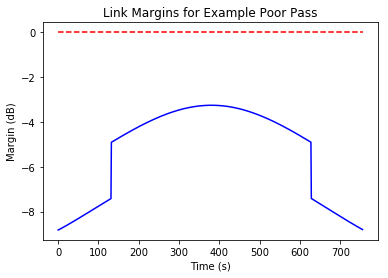

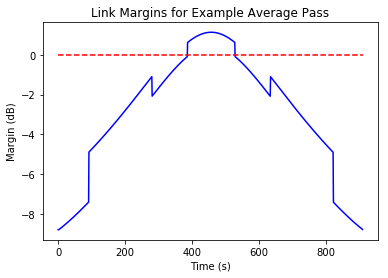

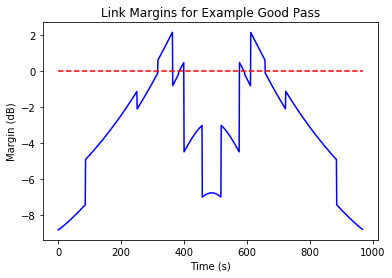

In [9]:
fig = []
types = ['Poor', 'Average', 'Good']

for i in range(0, len(outputs)):
    fig.append(plt.figure())
    p = fig[i].add_subplot(111)
    p.plot(range(0, len(margins[i])), margins[i], 'b', range(0, len(margins[i])), [0] * len(margins[i]), 'r--')
    plt.title('Link Margins for Example {} Pass'.format(types[i]))
    plt.xlabel('Time (s)')
    plt.ylabel('Margin (dB)')

    total_s = 0
    for m in margins[i]:
        if m > 0:
            total_s += 1

    print('Duration for {} pass above margin: {} seconds ({:.3} minutes)'.format(types[i], total_s, total_s/60))

### Conclusions

Considering the slightly lower gain and polarization losses, the link can only be completed for a fraction of the time that the first iteration can perform.

In [10]:
# other analysis for good/bad angles
import ephem

tle_old = ('NOAA 19 [+]', '1 33591U 09005A   18092.90091581  .00000055  00000-0  55075-4 0  9994',
       '2 33591  99.1353  69.4619 0014005 174.2137 185.9198 14.12266303471284')


# ---------------------------------------------------------------------------------------
# look angles for NOAA-19 satellite pass
# uses pyephem and online TLEs for next pass on given datetime
def compute_angles(tle=None, date=None):
	# handle the date argument
	date = datetime.datetime.now() if date is None else date 

	# use an old TLE or the argument
	if tle is None:
		name = 'NOAA 19 [+]'
		line1 = '1 33591U 09005A   18092.90091581  .00000055  00000-0  55075-4 0  9994'
		line2 = '2 33591  99.1353  69.4619 0014005 174.2137 185.9198 14.12266303471284'
	else:
		name = tle[0]
		line1 = tle[1]
		line2 = tle[2]

	# read in the tle
	tle_rec = ephem.readtle(name, line1, line2)

	# make a new ephem observer
	obs = ephem.Observer()
	obs.lon = 37.2725
	obs.lat = -80.4327
	obs.elev = 400
	obs.date = date

	# compute the orbit trajectory stuff
	tle_rec.compute(obs)

	# find the next pass
	next_pass = obs.next_pass(tle_rec)
	
	# move the current time to the next pass
	obs.date = next_pass[0]
	tle_rec.compute(obs)

	# empty lists to start
	alts  = []
	azs   = []
	times = []

	# loop through entire pass
	while tle_rec.alt > 0:
		# save results to list in radians
		alts.append(math.degrees(float(tle_rec.alt)))
		azs.append(math.degrees(float(tle_rec.az)))
		times.append(obs.date.datetime())

		# compute next second timestep
		obs.date = obs.date.datetime() + datetime.timedelta(seconds=1)
		# compute next pointing angle
		tle_rec.compute(obs)

	# return a tuple with the lists
	# format is (az, el, time)
	return (azs, alts, times)
# -------------------------------------------------------------------------------

date = 1
hour = 0
while True:
    angs = compute_angles(tle=tle_old, date='2018/04/{} {}:00.00'.format(date, hour))

    out = []

    # increment the elevation angle
    angle = 0.01
    lb_calc.orbit_elevation_angle     = angle * ureg.degrees
    lb_calc.atmospheric_loss          = atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
    lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

    for i, angle in enumerate(angs[1]):
        # compute the budget
        lb_calc.run()

        # ensure the computation was valid
        if not lb_calc.is_valid:
            raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')

        # save output as a tuple to output list
        out.append( lb_calc.link_margin )

        # increment the elevation angle
        lb_calc.orbit_elevation_angle     = angle * ureg.degrees
        lb_calc.atmospheric_loss          = atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
        lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

    # find length of time with positive margin
    above = False
    first = 0
    second = 0
    for i, val in enumerate( out ):
        if not above and val > 0:
            first = i
            above = True
        if above and val < 0:
            second = i
            break
    
    print( 'April {} at {} oclock:   '.format(date, hour), end='' )
    if second != first:
        time_above = angs[2][second] - angs[2][first]
        print( 'time above: ', str(angs[2][second] - angs[2][first]) )
    else:
        print( 'Never above.' )
    
    if hour < 22:
        hour += 2
    else:
        hour = 0
        date += 1
        if date > 28:
            break

April 1 at 0 oclock:   Never above.
April 1 at 2 oclock:   Never above.
April 1 at 4 oclock:   time above:  0:02:11.999988
April 1 at 6 oclock:   time above:  0:00:46.999988
April 1 at 8 oclock:   time above:  0:00:54
April 1 at 10 oclock:   time above:  0:03:09.999837
April 1 at 12 oclock:   time above:  0:01:07.999967
April 1 at 14 oclock:   time above:  0:00:45.999978
April 1 at 16 oclock:   time above:  0:01:09
April 1 at 18 oclock:   Never above.
April 1 at 20 oclock:   Never above.
April 1 at 22 oclock:   Never above.
April 2 at 0 oclock:   Never above.
April 2 at 2 oclock:   Never above.
April 2 at 4 oclock:   Never above.
April 2 at 6 oclock:   time above:  0:00:47.999968
April 2 at 8 oclock:   time above:  0:00:50.999999
April 2 at 10 oclock:   time above:  0:03:23.999879
April 2 at 12 oclock:   time above:  0:01:16.999933
April 2 at 14 oclock:   time above:  0:00:46
April 2 at 16 oclock:   time above:  0:00:59.999964
April 2 at 18 oclock:   Never above.
April 2 at 20 oclock: 

KeyboardInterrupt: 